### Что хочу сделать

1. Разбить на предложения, составить вектор частотности длин предложений нормированный к общему числу предложений в тексте (+ график распределения длин)
2. Посчитать общее и среднее число знаков препинания в предложениях с учетом длины предложения "пунктуационный профиль"
3. По каждому предложению сделать грамматический разбор (части речи с родами/падежами там где они применимы) посчитать частотность по частям речи нормированную на длину предложения) 
4. (в планах). Посчитать "любимый род" и "любимый падеж"
5. (в планах). Подсчитать N (100) любимых существительных и глаголов

Далле планирую собрать из этого модель kNN которая на входе получает любое количество предложений, делает по каждосму предложению kNN потом усредняет результат по всем предложениям входа

(Д.Шильцов)

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import boto3
import io

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
### загрузка из бакета
### конечно это слегка "перебор", нужно ключи потом через dotenv сделать
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id='YCAJErlaldUmioGbHQSqJ70MR',
    aws_secret_access_key='YCPSba_JgloNYSNWcnKO2CYCEB8PFR1Iwgr2jIUy',
    region_name='ru-cental1'
)
BUCKET_NAME = "mlds23-authorship-identification"
BUCKET_DIR = "dmitry_data/"

In [3]:
source_df = pd.read_csv("raw_data/found_df.csv")

# s3
#obj = s3.get_object(Bucket=BUCKET_NAME,Key="raw_data/found_df.csv")
#source_df = pd.read_csv(io.BytesIO(obj["Body"].read()))

source_df.head(2)

,Unnamed: 0,title,author,author_id,file_name,text_url
0,0,Арап Петра Великого,Александр Пушкин,0,aleksandr_pushkin_arap_petra_velikogo,https://ilibrary.ru/text/476/p.1/index.html
1,1,Дубровский,Александр Пушкин,0,aleksandr_pushkin_dubrovskij,https://ilibrary.ru/text/479/p.1/index.html


In [4]:
names = source_df[["author","author_id"]].groupby("author_id").max()
str(names.iloc[0,0])

'Александр Пушкин'

In [5]:
names = source_df["author"].unique()
ids = source_df["author_id"].unique()
names_arr = zip(ids,names)

data_dict = {}
for n in ids:
    with open("./stats-data/"+str(n)+".pkl", "rb") as fp:
        data_dict[n] = pickle.load(fp)

# грузим из s3
#for n in ids:
#    obj = s3.get_object(Bucket=BUCKET_NAME,Key= BUCKET_DIR +  str(n)+".pkl")
#    data_dict[n] = pickle.load(io.BytesIO(obj["Body"].read()))    



In [6]:
def get_name_by_id(aid):
    names_df = source_df[["author", "author_id"]].groupby("author_id").max()
    names = [name for name in names_df["author"]]
    return names[aid]

get_name_by_id(3)

'Антон Чехов'

### Распределение по длинам предложений

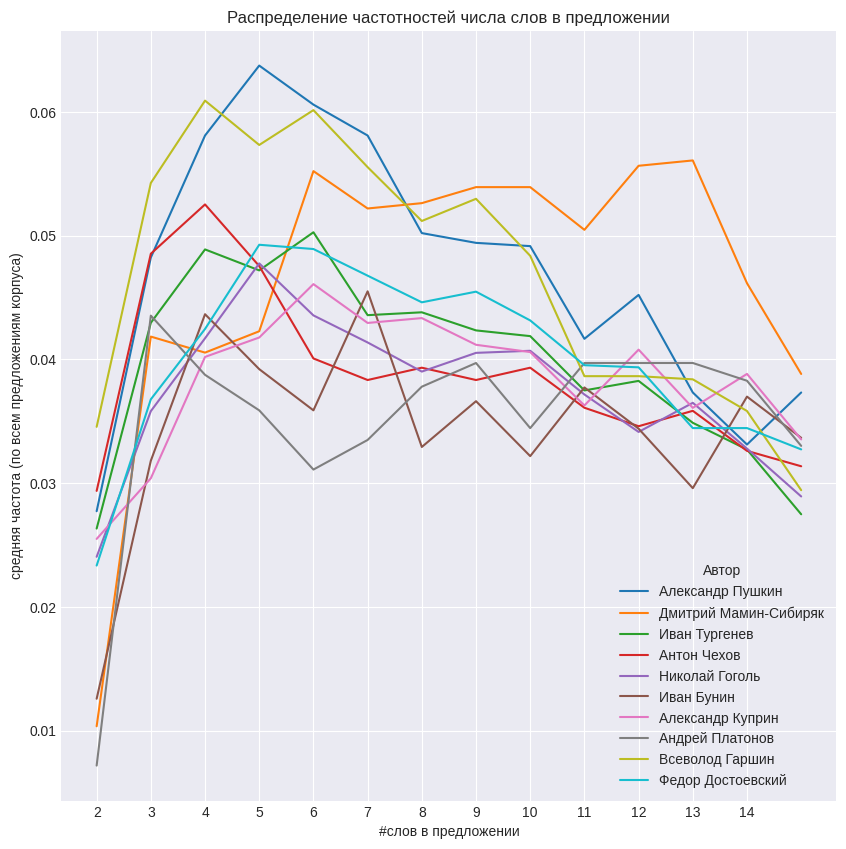

In [7]:
min_sent_length = 1
max_sent_length = 15

df_all = pd.DataFrame([], columns=["sentence_length", "freq",'Автор'])
for author_id in ids:
    # можно было их все в кучу свалить, но я хочу иметь возможноть удобно отсекать 
    # предложения длины больше заданной
    v = Counter(data_dict[author_id]["sentence_length"])
    df = pd.DataFrame(sorted(list(v.items()), key=lambda x: x[0]), columns=["sentence_length", "freq"])
    author  = get_name_by_id(author_id)
    df['Автор'] = pd.Series([author] * df.shape[0])
    df['freq'] = df['freq'] / df["freq"].sum()
    df['freq'] = df['freq'][min_sent_length:max_sent_length]
    
    df_all = pd.concat([df_all, df], ignore_index=True)

plt.figure(figsize=(10,10))    
plt.title("Распределение частотностей числа слов в предложении")
plt.xlabel("#слов в предложении")
plt.xticks(range(min_sent_length,max_sent_length))
plt.ylabel("средняя частота (по всем предложениям корпуса)")
sns.lineplot(data=df_all, x="sentence_length", y="freq", hue="Автор", palette="tab10", legend="full" )
plt.show()


### Распределение числа знаков препинания 

совокупное не так интересно как с разбивкой на длины. 

In [8]:
## "!\'()*,-./:;?

columns=["Автор", "Длина пр-я", 
         'sgn "', 'sgn !', "sgn '", "sgn (", "sgn )", "sgn *", 
         "sgn ,", "sgn -", "sgn .", "sgn :", "sgn ;","sgn ?"]

df_all = pd.DataFrame([], columns=columns)

for author_id in ids:
    df_all_tmp = pd.DataFrame(data_dict[author_id]["punctuation"], columns=columns[2:])
    df_all_tmp['Длина пр-я'] = pd.Series(data_dict[author_id]["sentence_length"])
    
    author  = get_name_by_id(author_id)
    df_all_tmp['Автор'] = pd.Series([author] * df_all_tmp.shape[0])
    df_all_tmp = df_all_tmp[[
         "Автор", "Длина пр-я", 
         "sgn !", 'sgn "', "sgn '", "sgn (", "sgn )", "sgn *", 
         "sgn ,", "sgn -", "sgn .", "sgn :", "sgn ;","sgn ?"]]
    df_all = pd.concat([df_all, df_all_tmp])


In [9]:
df_aggr = df_all.groupby(['Автор','Длина пр-я']).mean().reset_index()

In [10]:
df_aggr.sample(10)

,Автор,Длина пр-я,"sgn """,sgn !,sgn ',sgn (,sgn ),sgn *,"sgn ,",sgn -,sgn .,sgn :,sgn ;,sgn ?
205,Андрей Платонов,28,0.0,0.208333,0.0,0.0,0.0,0.0,3.791667,0.333333,1.541667,0.125,0.083333,0.25
100,Александр Пушкин,11,0.0,0.07571,0.003155,0.009464,0.009464,0.015773,1.100946,0.047319,1.041009,0.078864,0.088328,0.088328
556,Иван Бунин,71,0.0,0.333333,0.0,0.0,0.0,0.0,12.333333,0.0,5.0,0.0,0.0,0.0
420,Всеволод Гаршин,79,0.0,0.0,0.0,1.0,1.0,0.0,11.0,2.0,4.0,0.0,2.0,1.0
383,Всеволод Гаршин,36,0.0,0.166667,0.0,0.083333,0.083333,0.0,5.5,0.416667,3.083333,0.083333,0.083333,0.416667
885,Федор Достоевский,49,0.0,0.4,0.0,0.04,0.04,0.04,7.72,1.08,2.28,0.36,0.36,0.2
835,Николай Гоголь,194,0.0,2.0,0.0,0.0,0.0,0.0,35.0,0.0,2.0,1.0,2.0,0.0
630,Иван Тургенев,20,0.0,0.156863,0.006536,0.022876,0.022876,0.01634,2.643791,0.254902,2.0,0.173203,0.24183,0.24183
921,Федор Достоевский,85,0.0,0.6,0.0,0.0,0.0,0.0,14.2,0.6,2.2,0.2,0.8,0.0
594,Иван Бунин,122,0.0,0.0,0.0,0.0,0.0,0.0,23.0,2.0,4.0,0.0,1.0,0.0


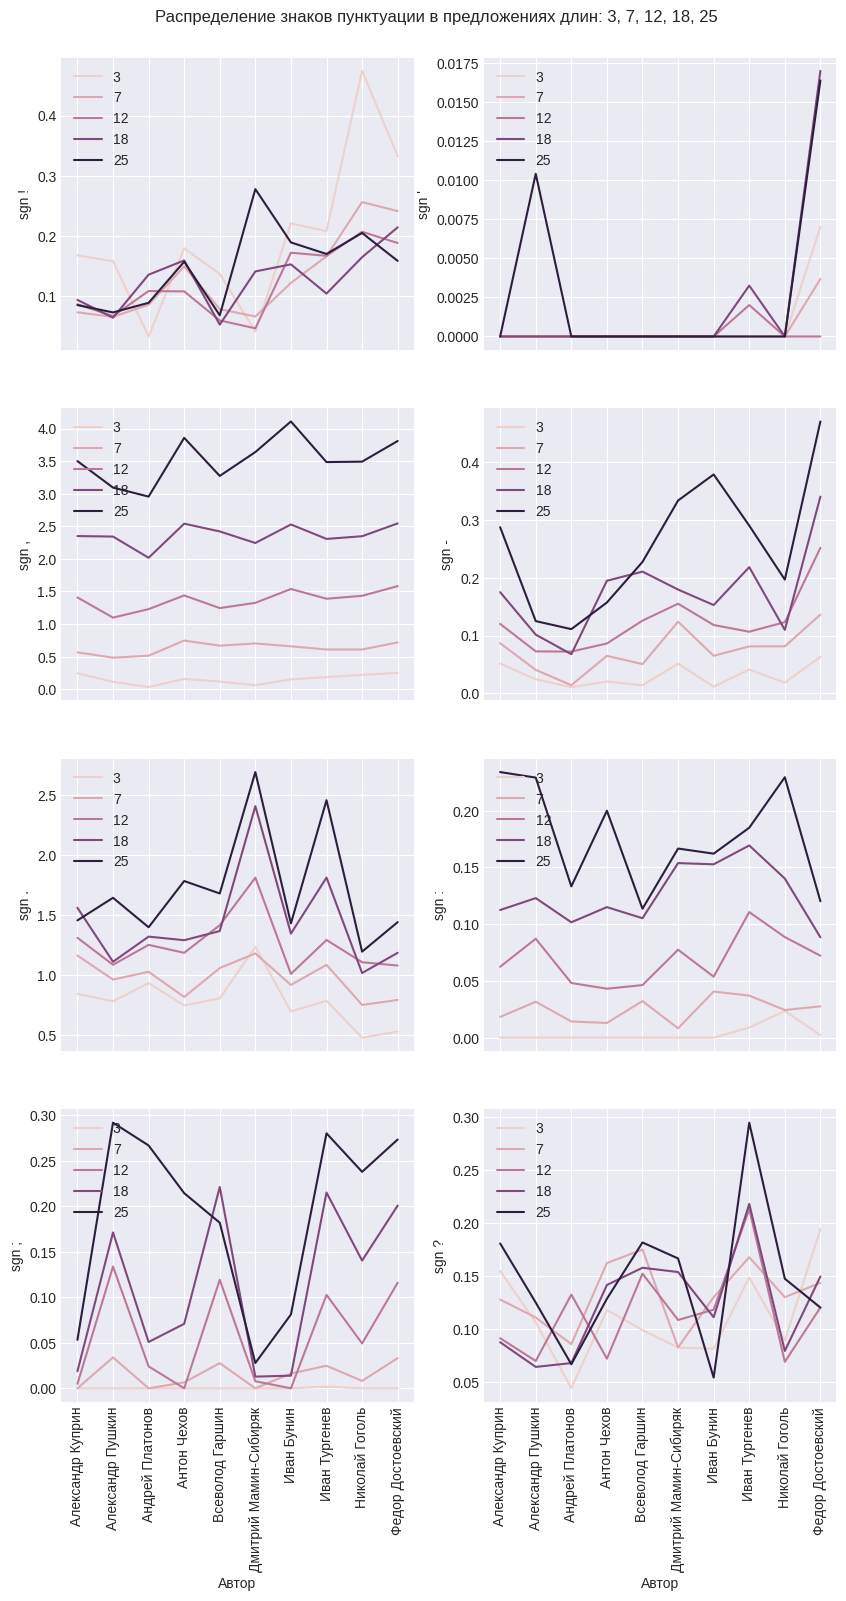

In [11]:
arr = [3,7,12,18,25]
words = np.array(arr)
pun = '!\',-.:;?'

fig, axes = plt.subplots(len(pun)//2, 2, figsize=(10, 16), sharex=True)
fig.suptitle(f"Распределение знаков пунктуации в предложениях длин: " + ", ".join(map(str, arr)))
plt.subplots_adjust(top=.95)
                    
for i in range(len(pun)):
    sign = "sgn " + pun[i]
    sns.lineplot(df_aggr[df_aggr["Длина пр-я"].apply(lambda x: x in words)][['Автор', sign, 'Длина пр-я']], 
                 x='Автор', y=sign, hue='Длина пр-я', ax=axes[i//2][i%2])
    axes[i//2][i%2].tick_params(rotation=90, axis='x')
    axes[i//2][i%2].legend(loc='upper left')

### Анализ частотности по частям речи

In [12]:
## части речи

parts =  ['A', 'ADV', 'ADVPRO', 'ANUM', 'APRO', 'COM', 'CONJ', 'INTJ', 'NUM', 'PART', 'PR', 'S', 'SPRO', 'V']
columns = ["Автор", "Длина пр-я"] + parts 

df_all = pd.DataFrame([], columns=columns)

for author_id in ids:
    df_all_tmp = pd.DataFrame([], columns=["Автор", "Длина пр-я"])       
    df_all_tmp['Длина пр-я'] = pd.Series(data_dict[author_id]["sentence_length"])
    author  = get_name_by_id(author_id)
    df_all_tmp['Автор'] = pd.Series([author] * df_all_tmp.shape[0])        

    gr_dicts = []
    for i in range(len(data_dict[author_id]['gram'])):
        # проходим по предложениям
        gr_dict = {x : 0 for x in parts}
        for gr in data_dict[author_id]['gram'][i][0]:
            gr_dict[gr] += 1
        gr_dicts.append(gr_dict)
    gr_df = pd.DataFrame(gr_dicts)
    df_all_tmp = pd.concat([df_all_tmp, gr_df], axis=1)
    df_all = pd.concat([df_all, df_all_tmp])

df_aggr = df_all.groupby(['Автор','Длина пр-я']).mean().reset_index()    
print(df_aggr.sample(2))

                Автор  Длина пр-я         A       ADV    ADVPRO ANUM  \
215   Андрей Платонов          38  2.352941  2.294118  0.352941  0.0   
92   Александр Пушкин           3  0.147139  0.217984  0.046322  0.0   

         APRO  COM      CONJ      INTJ       NUM      PART        PR  \
215  1.705882  0.0  4.058824       0.0  0.411765  1.294118  4.058824   
92   0.081744  0.0  0.079019  0.029973  0.002725  0.108992  0.043597   

            S      SPRO         V  
215  9.470588  3.941176  7.352941  
92   0.762943  0.408719  0.893733  


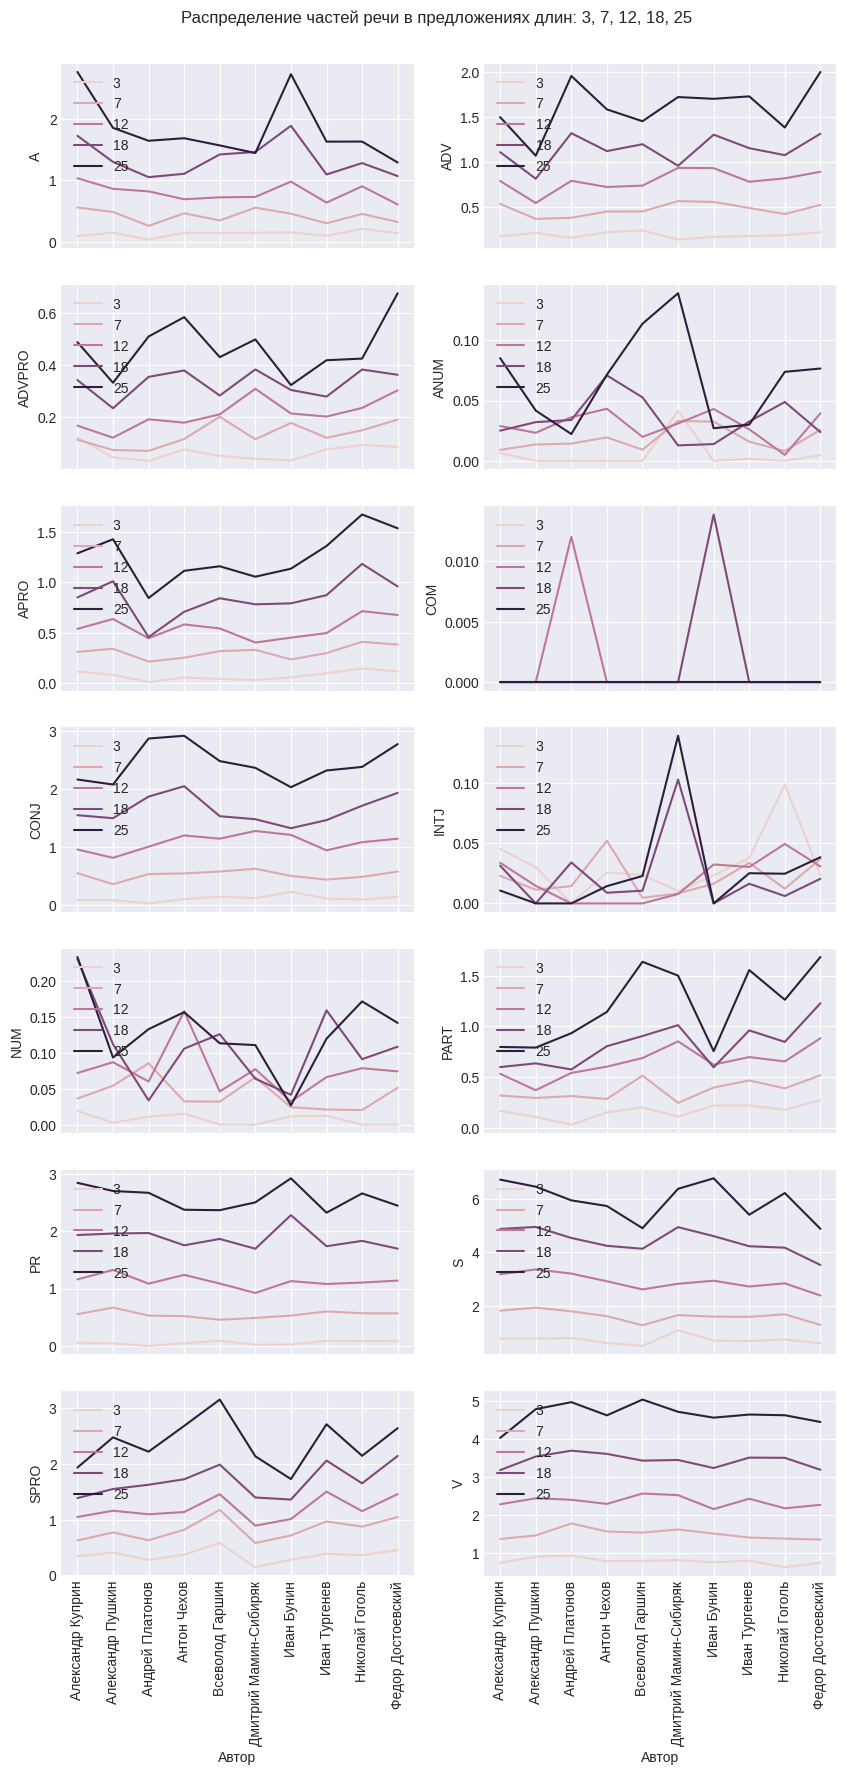

In [14]:
arr = [3,7,12,18,25]
words = np.array(arr)

parts =  ['A', 'ADV', 'ADVPRO', 'ANUM', 'APRO', 'COM', 'CONJ', 'INTJ', 'NUM', 'PART', 'PR', 'S', 'SPRO', 'V']
words = np.array(arr)

fig, axes = plt.subplots(len(parts)//2, 2, figsize=(10, 18), sharex=True)
fig.suptitle(f"Распределение частей речи в предложениях длин: " + ", ".join(map(str, arr)))
plt.subplots_adjust(top=.95)
                    
for i in range(len(parts)):
    part = parts[i]
    sns.lineplot(df_aggr[df_aggr["Длина пр-я"].apply(lambda x: x in words)][['Автор', part, 'Длина пр-я']], 
                 x='Автор', y=part, hue='Длина пр-я', ax=axes[i//2][i%2])
    axes[i//2][i%2].tick_params(rotation=90, axis='x')
    axes[i//2][i%2].legend(loc='upper left')